In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class consts:
    pi = 3.141592
    c = 3e8
    e = 1.6e-19

    mu_B = 5.788 * 10**-9   # eV / Gauss
    hbar = 6.58 * 10**-16   # eV * s
class setup:
    dummy = 0
    probe_d = 14.3          # mm
    probe_d_err = 0.1       # mm
    probe_N = 49            # turns
    freq = 50               # Hz
    freq_err = 1            # Hz
    

In [3]:
data = mipt.read_excel('data/542.xlsx', usecols=('A', 'B'), header=(0)).dropna()
fmt = {
    'I, A' : 'I',
    'N, 1/s' : 'N',
}

data = mipt.map_excel(data, fmt)
data.sort_values(by='I', ignore_index=True, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,I,N
0,0.00,1.360
1,0.20,1.180
2,0.40,1.470
3,0.60,1.610
4,0.80,2.359
5,1.00,4.809
6,1.20,8.807
7,1.40,11.686
8,1.60,13.676
9,1.80,14.106


In [15]:
E0 = 511   # keV -- Rest energy
c = 1      #     -- Speed of light

def T2p(T): # keV / speed-of-light
    return (((T + E0) / c)**2 - (E0 / c)**2)**0.5

def p2T(p): # keV
    return (E0**2 + p**2)**0.5 - E0

Tk = 624   # keV -- Conversion peak
pk = T2p(Tk)
print(f"pk = {pk:.4g} keV / speed-of-light")

argmax = np.argmax(data['N'])
Nk = data['N'][argmax]
Ik = data['I'][argmax]
k = pk / Ik
print(f"k = {k:.4g} keV / (speed-of-light * A)")

data['p'] = k * data['I']
data['T'] = p2T(data['p'])
data

pk = 1013 keV / speed-of-light
k = 311.8 keV / (speed-of-light * A)


,I,N,p,T
0,0.00,1.360,0.000000,0.000000
1,0.20,1.180,62.366855,3.791826
2,0.40,1.470,124.733710,15.003326
3,0.60,1.610,187.100565,33.176094
4,0.80,2.359,249.467420,57.643116
5,1.00,4.809,311.834276,87.633123
6,1.20,8.807,374.201131,122.362050
7,1.40,11.686,436.567986,161.095682
8,1.60,13.676,498.934841,203.182732
9,1.80,14.106,561.301696,248.065606


In [66]:
fmt = {
    'I' : [r'$I$, A', '{:.2f}'],
    'N' : [r'$N$, 1/с', '{:.2f}'],
    'p' : [r'$p_e$, $\text{кэВ}/\mathcal{C}$', '{:.2f}'],
    'T' : [r'$T_e$, кэВ', '{:.2f}'],
}

table = mipt.table(data, fmt)
display(table.rename().data)
table.to_latex('gen/data.tex')

,"$I$, A","$N$, 1/с","$p_e$, $\text{кэВ}/\mathcal{C}$","$T_e$, кэВ"
0,0.00,1.360,0.000000,0.000000
1,0.20,1.180,62.366855,3.791826
2,0.40,1.470,124.733710,15.003326
3,0.60,1.610,187.100565,33.176094
4,0.80,2.359,249.467420,57.643116
5,1.00,4.809,311.834276,87.633123
6,1.20,8.807,374.201131,122.362050
7,1.40,11.686,436.567986,161.095682
8,1.60,13.676,498.934841,203.182732
9,1.80,14.106,561.301696,248.065606


roots=[3.15084789414115, 3.3435204369157954]
perr = 30.04 keV/c


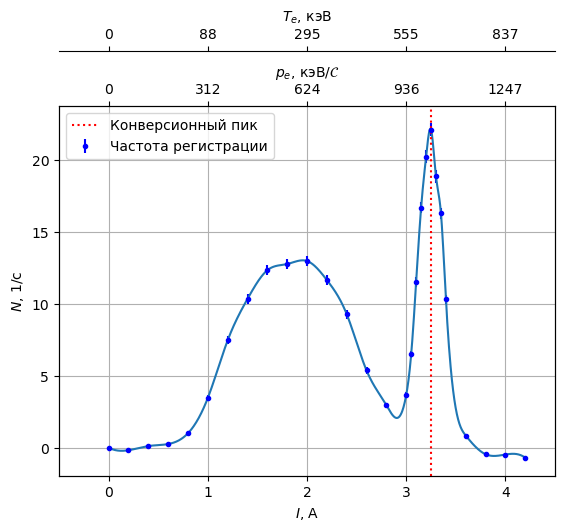

In [89]:
N = data['N'] - data['N'][0]
Nerr = np.abs(N) * (np.abs(N) * 100)**(-0.5)        # Nerr / N = 1 / sqrt(N * 100 seconds)
I = data['I']
p = data['p'] 
T = data['T']

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def plot_main():
    fig, host = plt.subplots()
    
    host.errorbar(I, N, yerr=Nerr, label="Частота регистрации", marker='.', c='b', linestyle='')

    equ = UnivariateSpline(I, N, s=0)
    x = np.linspace(min(I), max(I), 1000)
    host.plot(x, equ(x))

    host.axvline(x = Ik, c='r', linestyle=':', label='Конверсионный пик')
    # host.axhline(y = Nk/1.2, c='r', linestyle=':')
    roots = []
    roots.append(sp.optimize.fsolve(lambda x: equ(x) - Nk / 1.4, x0=Ik - 0.1)[0])
    roots.append(sp.optimize.fsolve(lambda x: equ(x) - Nk / 1.4, x0=Ik + 0.1)[0])
    print(f"{roots=}")
    perr = k * (roots[1] - roots[0]) / 2
    Terr = perr / p * T
    print(f"perr = {perr:.2f} keV/c")

    # Beginning of ticks juggling to align all scales

    # Set limits to even values
    left  = np.floor(min(I) - 0.1)
    right = np.ceil(max(I) + 0.1)
    host.set_xlim(left, right)

    # Copy host scale
    ax1 = host.twiny()
    ax2 = host.twiny()

    # Offset the top spine of ax2. The ticks and label have already been
    # placed on the right by twiny above.
    ax2.spines["top"].set_position(("axes", 1.15))
    # Having been created by twiny, ax2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(ax2)
    # Second, show the top spine.
    ax2.spines["top"].set_visible(True)

    # Convert automatic ticks of current to string ticks for impulse and energy
    ticks = host.get_xticks()
    Pstrings = [f"{t:.0f}" for t in k*ticks]
    Tstrings = [f"{t:.0f}" for t in p2T(k*ticks)]
    ax1.set_xticks(ticks, Pstrings)
    ax2.set_xticks(ticks, Tstrings)

    # Reduce limits to more sensible values
    left  = 0.5 * np.floor(2 * (min(I) - 0.1))
    right = 0.5 * np.ceil(2 * (max(I) + 0.1))
    host.set_xlim(left, right)
    ax1.set_xlim(left, right)
    ax2.set_xlim(left, right)

    host.set_xlabel("$I$, А")
    host.set_ylabel("$N$, 1/c")
    ax1.set_xlabel("$p_e$, кэВ/$\mathcal{C}$")
    ax2.set_xlabel("$T_e$, кэВ")

    host.legend()
    host.grid(True)

    return fig, host, perr, Terr

fig, host, perr, Terr = plot_main()
fig.savefig('gen/spectrum.pdf', bbox_inches='tight')
plt.show()

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,301.963888,15104.008759,0.000228,1.077421e-08,-0.012747,-8.439414e-07,1.251924e-08,0.000483,0.000004


T_max = (572 +- 25) keV


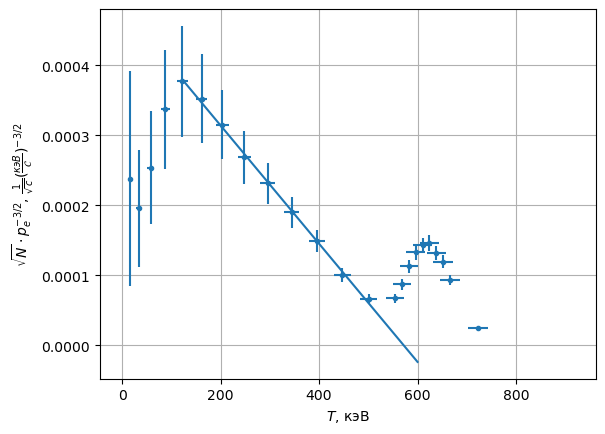

In [84]:
y = N**0.5 / p**1.5
yerr = y * ((0.5 * Nerr / N)**2 + (2.5 * perr / p)**2)**0.5
x, y, _ = mipt.plot(T, y, xerr=Terr, yerr=yerr, begin=6, end=14, x_max=600)

plt.xlabel(r"$T$, кэВ")
plt.ylabel(r"$\sqrt{N} \cdot p_e^{-3/2}$, $\frac{1}{\sqrt{с}} (\frac{кэВ}{\mathcal{C}} )^{-3/2}$")
plt.grid()
plt.savefig("gen/fermi.pdf", bbox_inches='tight')

mnk = mipt.mnk(x, y).data
display(mnk)
a  = mnk['a' ][0]
da = mnk['da'][0]
b  = mnk['b' ][0]
db = mnk['db'][0]
T_max = -b/a
T_max_err = T_max * ((db/b)**2 + (da/a)**2  +  0.04**2)**0.5 # Last addend due to vertical error. I wont do it manually...
print(f"T_max = ({T_max:.0f} +- {T_max_err:.0f}) keV")


In [85]:

# Print least square approximation
fmt = {
    '<x>' : [r'$\overline{x}$', '{:.2f}'],
    'sx' : [r'$S_x$', '{:.2f}'],
    '<y>' : [r'$\overline{y}$', '{:.2e}'],
    'sy' : [r'$S_y$', '{:.2e}'],
    'rxy' : [r'$R_{xy}$', '{:.2e}'],
    'a' : [r'$a$', '{:.2e}'],
    'da' : [r'$\Delta a$', '{:.2e}'],
    'b' : [r'$b$', '{:.2e}'],
    'db' : [r'$\Delta b$', '{:.2e}'],
}

table = mipt.table(mnk, fmt)
table.to_latex('gen/mnk.tex', na_rep='')
display(table.rename().get_data())

,$\overline{x}$,$S_x$,$\overline{y}$,$S_y$,$R_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,301.963888,15104.008759,0.000228,1.077421e-08,-0.012747,-8.439414e-07,1.251924e-08,0.000483,0.000004


roots=[3.1896518699106755, 3.2899087588908253]


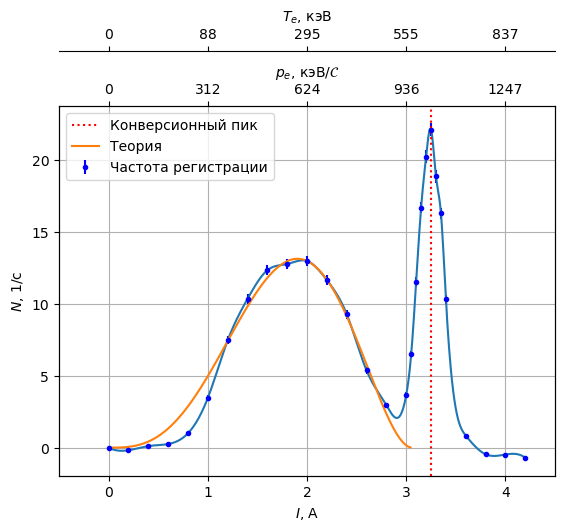

In [86]:
# Evaluate normalization for fermi
C = N[10] / (p[10]**3 * (T_max - p2T(p[10]))**2)

def fermi(I_rng):
    p_rng = k * I_rng
    return C * p_rng**3 * (T_max - p2T(p_rng))**2

fig, host,_, _ = plot_main()

I_rng = np.linspace(min(I), max(I)/1.38, 1000)
host.plot(I_rng, fermi(I_rng), label="Теория")
host.legend()

plt.savefig("gen/spectrum_fermi.pdf", bbox_inches='tight')
plt.show()